In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import pyplot
import seaborn as sns
import yfinance as yf

# Getting Bitcoin Prices with API from YahooFinance

In [2]:
df = yf.download("BTC-USD", start="2015-01-01", end="2019-12-31", interval = "1d")
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-01,320.434998,320.434998,314.002991,314.248993,314.248993,8036550
2015-01-02,314.079010,315.838989,313.565002,315.032013,315.032013,7860650
2015-01-03,314.846008,315.149994,281.082001,281.082001,281.082001,33054400
2015-01-04,281.145996,287.230011,257.612000,264.195007,264.195007,55629100
2015-01-05,265.084015,278.341003,265.084015,274.473999,274.473999,43962800


# Cleaning and Preprocessing Data

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

len(df)

1826

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2015-01-01 to 2019-12-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1826 non-null   float64
 1   High       1826 non-null   float64
 2   Low        1826 non-null   float64
 3   Close      1826 non-null   float64
 4   Adj Close  1826 non-null   float64
 5   Volume     1826 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 99.9 KB


In [5]:
df['Daily_Bitcoin_Price'] = df['Close']
df.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume', 'Close'], axis=1, inplace=True)

In [6]:
df.info()            #The dates are used as the index and are in datetime format

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2015-01-01 to 2019-12-31
Data columns (total 1 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Daily_Bitcoin_Price  1826 non-null   float64
dtypes: float64(1)
memory usage: 28.5 KB


In [7]:
df.isnull().sum()

Daily_Bitcoin_Price    0
dtype: int64

In [557]:
df.head()

,Daily_Bitcoin_Price
Date,
2015-01-01,314.248993
2015-01-02,315.032013
2015-01-03,281.082001
2015-01-04,264.195007
2015-01-05,274.473999


# Visualizing the Bitcoin Price data - Daily prices from 2015 through 2019

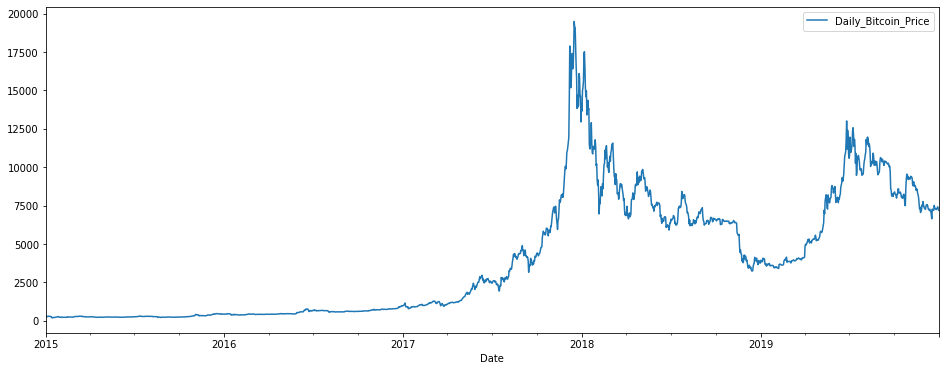

In [9]:
df.plot(figsize = (16,6))      #has expontial upward trend

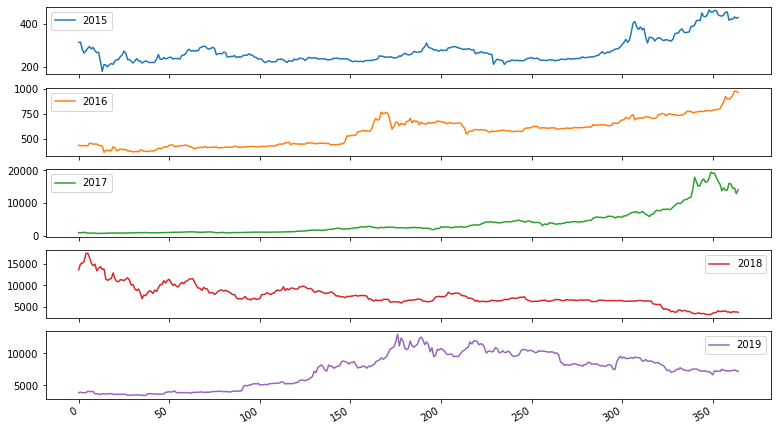

In [10]:
# Use pandas grouper to group values using annual frequency                     #Are there any yearly patterns? no
year_groups = df.groupby(pd.Grouper(freq ='A'))

# Create a new DataFrame and store yearly values in columns 
df_annual = pd.DataFrame()

for yr, group in year_groups:
    df_annual[yr.year] = pd.Series(group.values.ravel())      #needed to add pd.Series to fix error
    
# Plot the yearly groups as subplots
df_annual.plot(figsize = (13,8), subplots=True, legend=True);

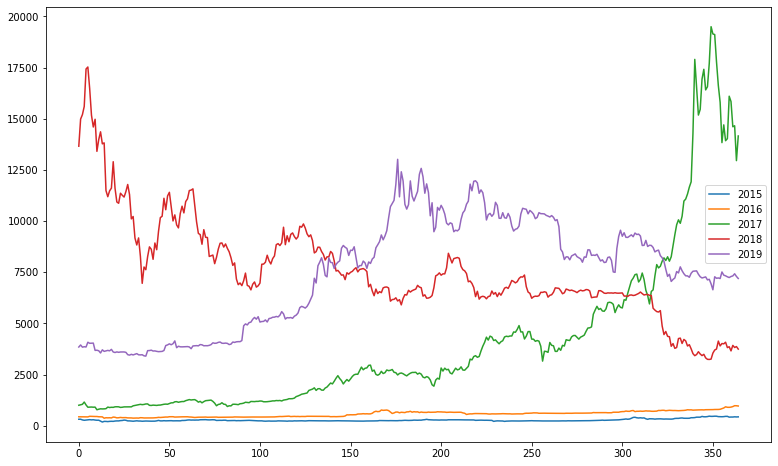

In [11]:
# Plot overlapping yearly groups, does not show any annual patterns
for yr, group in year_groups:
    df_annual[yr.year] = pd.Series(group.values.ravel())     
    
df_annual.plot(figsize = (13,8), subplots=False, legend=True)


In [158]:
roll_mean = df.rolling(window=8, center=False).mean()  #Graph is exponential, I'll show it using rolling statists
roll_std = df.rolling(window=8, center=False).std()

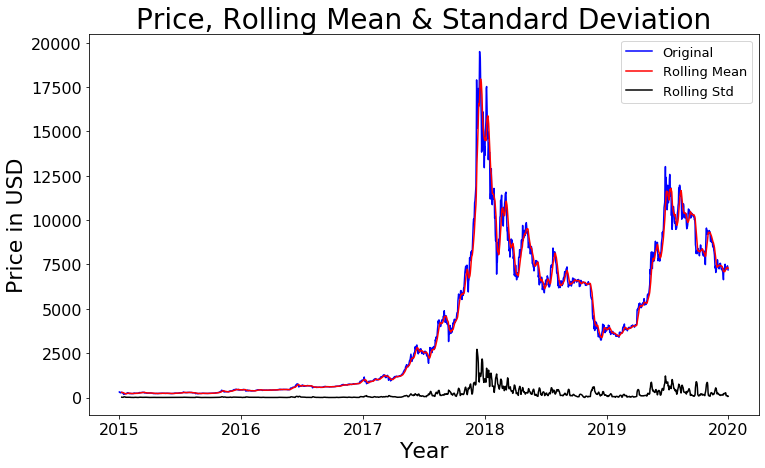

In [626]:
fig = plt.figure(figsize=(12,7))              #not stationary
plt.plot(df, color='blue', label='Original')
plt.plot(roll_mean, color='red', label='Rolling Mean')
plt.plot(roll_std, color='black', label = 'Rolling Std')
plt.legend(loc='best', fontsize=13)
plt.title('Price, Rolling Mean & Standard Deviation', fontsize=28)
plt.tick_params(axis='both', labelsize=16)
plt.xlabel('Year', fontsize=22)
plt.ylabel('Price in USD', fontsize=22)
plt.show(block=False)

Bitcoin has an exponential upward trend and an increase in variance 

# Time Series Decomposition

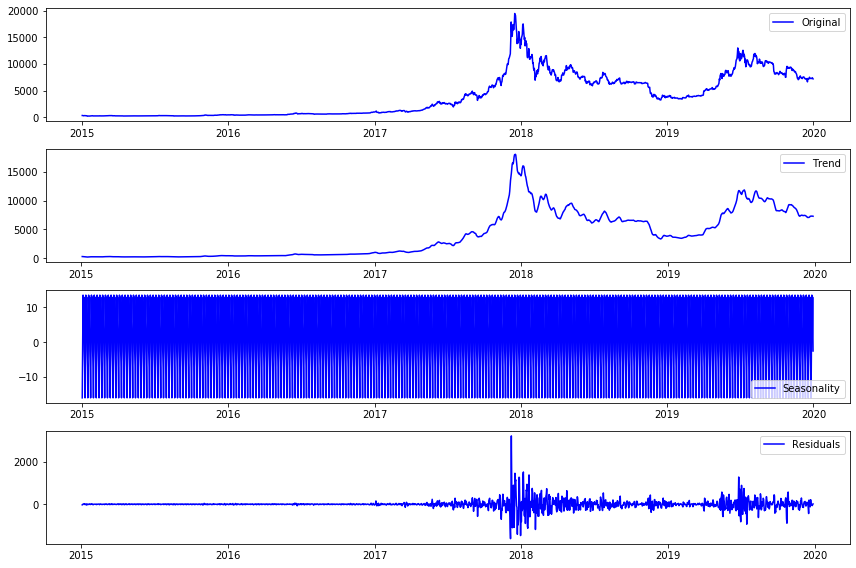

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df)

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(df, label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11d53c910>]],
      dtype=object)

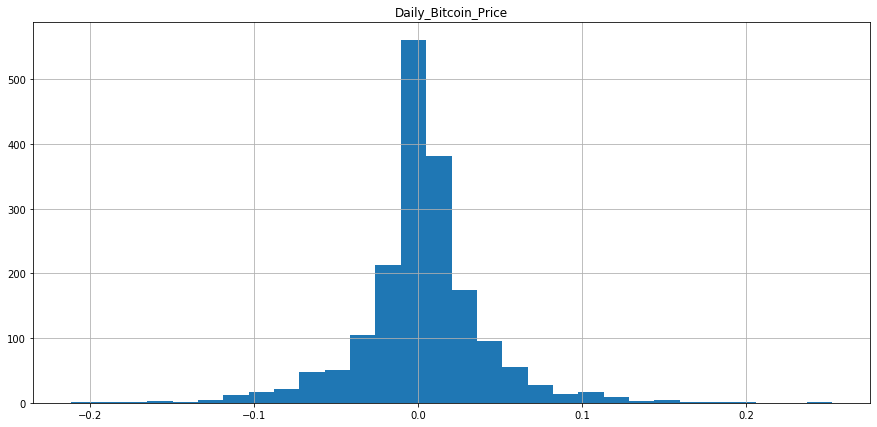

In [15]:
df_pct = df.pct_change()     #distribution of daily returns
df_pct.hist(figsize=(15,7), bins=30)

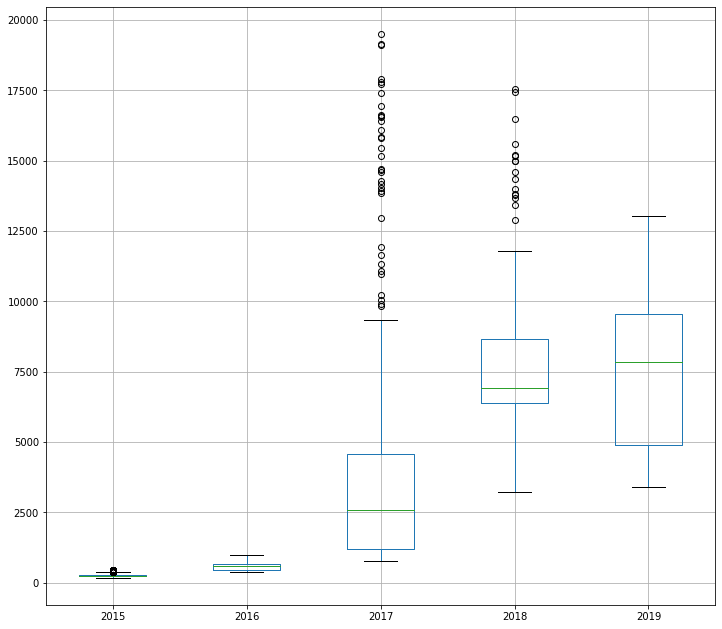

In [50]:
df_annual.boxplot(figsize = (12,11))

# Making the Time Series Stationary 

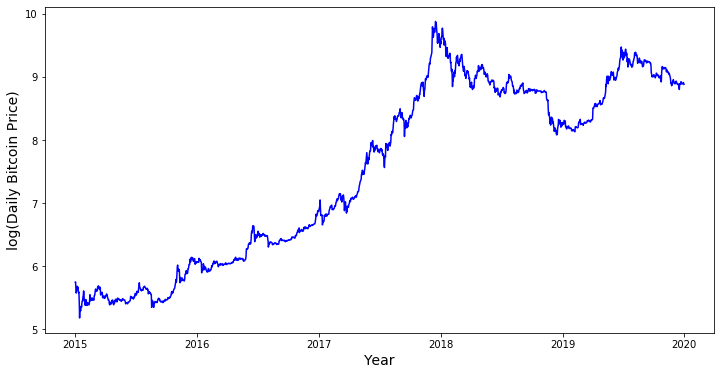

In [16]:
df_log = pd.Series(np.log(df['Daily_Bitcoin_Price']))        #taking the log to create stationary data
fig = plt.figure(figsize=(12,6))
plt.plot(df_log, color='blue')
plt.xlabel('Year', fontsize=14)
plt.ylabel('log(Daily Bitcoin Price)', fontsize=14)
plt.show()

After taking the log transformation, there is still an exponential trend

In [17]:
from statsmodels.tsa.stattools import adfuller                           #The Dickey-Fuller Test

dftest_log = adfuller(df_log)

# Extract and display test results in a user friendly manner
dfoutput_log = pd.Series(dftest_log[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest_log[4].items():
    dfoutput_log['Critical Value (%s)'%key] = value
    
print ('Results of Dickey-Fuller test: \n')

print(dfoutput_log)

Results of Dickey-Fuller test: 

Test Statistic                   -0.839514
p-value                           0.807239
#Lags Used                        0.000000
Number of Observations Used    1825.000000
Critical Value (1%)              -3.433938
Critical Value (5%)              -2.863125
Critical Value (10%)             -2.567614
dtype: float64


p-value over .05, not stationary yet

# Differencing

In [20]:
df_diff_log = df_log.diff(periods=1)     #1 period lag
df_diff_log.head()

Date
2015-01-01         NaN
2015-01-02    0.002489
2015-01-03   -0.114028
2015-01-04   -0.061959
2015-01-05    0.038169
Name: Daily_Bitcoin_Price, dtype: float64

In [22]:
df_diff.dropna(inplace=True)
df_diff_log.head()

Date
2015-01-01         NaN
2015-01-02    0.002489
2015-01-03   -0.114028
2015-01-04   -0.061959
2015-01-05    0.038169
Name: Daily_Bitcoin_Price, dtype: float64

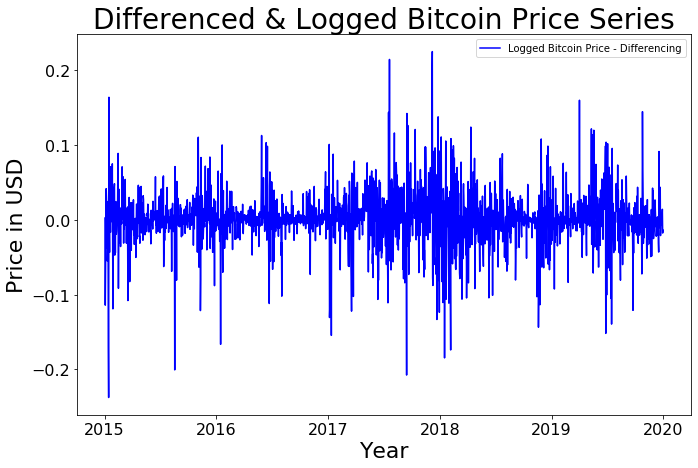

In [143]:
fig = plt.figure(figsize=(11,7))
plt.plot(df_diff_log, color='blue',label='Logged Bitcoin Price - Differencing')
plt.legend(loc='best')
plt.title('Differenced & Logged Bitcoin Price Series', fontsize=28)
plt.xlabel('Year', fontsize=22)
plt.ylabel('Price in USD', fontsize=22)
plt.tick_params(axis='both', labelsize=16)
plt.show(block=False)

Looks stationary, will test for stationarity again

# Testing for Stationarity

In [161]:
roll_mean_diff_log = df_diff_log.rolling(window=8, center=False).mean()
roll_std_diff_log = df_diff_log.rolling(window=8, center=False).std()

In [162]:
roll_mean_diff_log.head()

Date
2015-01-02   NaN
2015-01-03   NaN
2015-01-04   NaN
2015-01-05   NaN
2015-01-06   NaN
Name: Daily_Bitcoin_Price, dtype: float64

In [164]:
roll_std_diff_log.head()

Date
2015-01-02   NaN
2015-01-03   NaN
2015-01-04   NaN
2015-01-05   NaN
2015-01-06   NaN
Name: Daily_Bitcoin_Price, dtype: float64

In [165]:
df_diff_log.head()

Date
2015-01-02    0.002489
2015-01-03   -0.114028
2015-01-04   -0.061959
2015-01-05    0.038169
2015-01-06    0.041796
Name: Daily_Bitcoin_Price, dtype: float64

In [166]:
roll_mean_diff_log.dropna(inplace=True)
roll_std_diff_log.dropna(inplace=True)
df_diff_log.dropna(inplace=True)

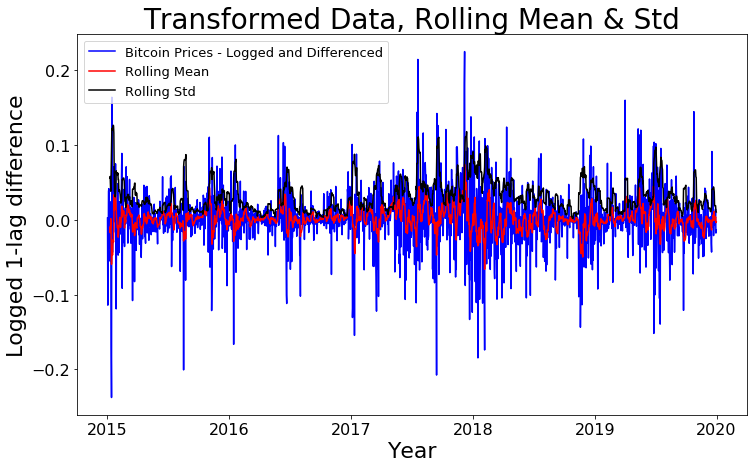

In [168]:
fig = plt.figure(figsize=(12,7))                      #Rolling Statistics, mean and std look consistent over time
plt.plot(df_diff_log, color='blue', label='Bitcoin Prices - Logged and Differenced')
plt.plot(roll_mean_diff_log, color='red', label='Rolling Mean')
plt.plot(roll_std_diff_log, color='black', label = 'Rolling Std')
plt.legend(loc='best', fontsize=13)
plt.title('Transformed Data, Rolling Mean & Std', fontsize=28)
plt.xlabel('Year', fontsize=22)
plt.ylabel('Logged 1-lag difference', fontsize=22)
plt.tick_params(axis='both', labelsize=16)
plt.show(block=False)

In [37]:
dftest_diff_log = adfuller(df_diff_log)          #The Dickey-Fuller Test

# Extract and display test results in a user friendly manner
dfoutput_diff_log = pd.Series(dftest_diff_log[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest_diff_log[4].items():
    dfoutput_diff_log['Critical Value (%s)'%key] = value
    
print ('Results of Dickey-Fuller test: \n')

print(dfoutput_diff_log)

Results of Dickey-Fuller test: 

Test Statistic                  -42.648484
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1824.000000
Critical Value (1%)              -3.433940
Critical Value (5%)              -2.863126
Critical Value (10%)             -2.567614
dtype: float64


Data is stationary, p-value is zero, less than .05

# Autocorrelation Function

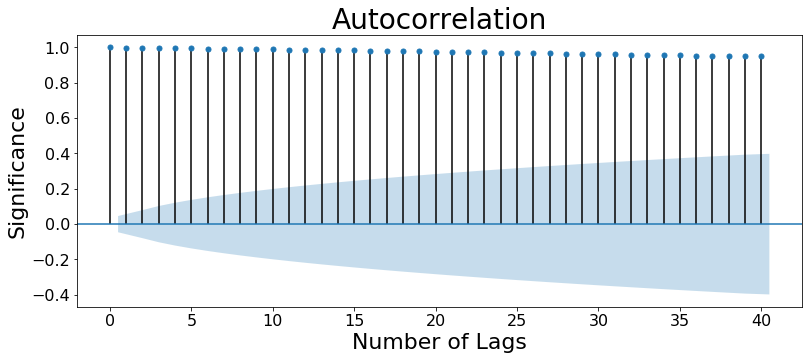

In [179]:
from statsmodels.graphics.tsaplots import plot_acf       #Logged Bitcoin Prices, statsmodels version
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 13, 5

plot_acf(df_log, lags=40)    
plt.title('Autocorrelation', fontsize=28)
plt.xlabel('Number of Lags', fontsize=22)
plt.ylabel('Significance', fontsize=22)
plt.tick_params(axis='both', labelsize=16)

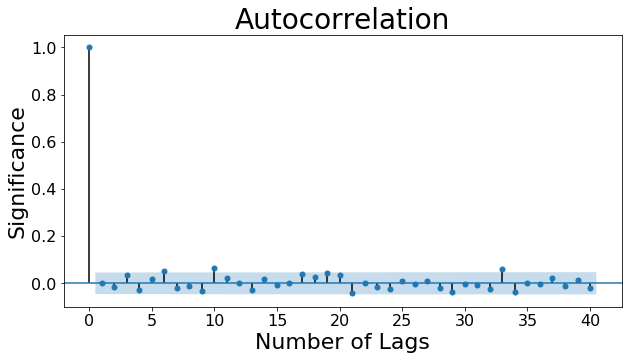

In [189]:
rcParams['figure.figsize'] = 10, 5     #Logged and differenced Bitcoin Prices, statsmodels version
plot_acf(df_diff_log, lags=40)
plt.title('Autocorrelation', fontsize=28)
plt.xlabel('Number of Lags', fontsize=22)
plt.ylabel('Significance', fontsize=22)
plt.tick_params(axis='both', labelsize=16)

No significant lags for logged and differenced prices. The Autocorrelation Function will tell us how many significant lags to put into a MA model.

# Partial Autocorrelation Function

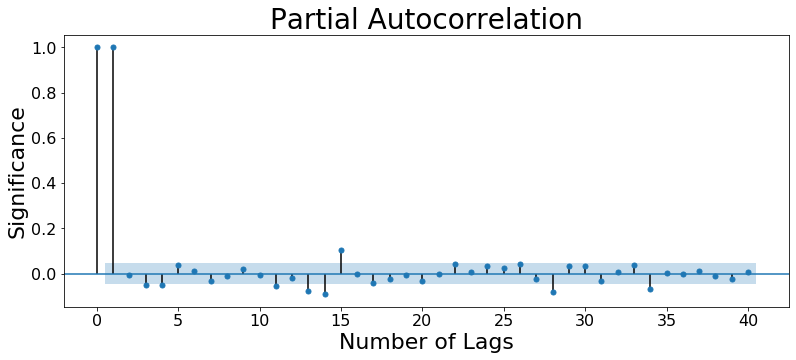

In [178]:
from statsmodels.graphics.tsaplots import plot_pacf       #Logged Bitcoin Prices, statsmodels version
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 13, 5

plot_pacf(df_log, lags=40)
plt.title('Partial Autocorrelation', fontsize=28)
plt.xlabel('Number of Lags', fontsize=22)
plt.ylabel('Significance', fontsize=22)
plt.tick_params(axis='both', labelsize=16)

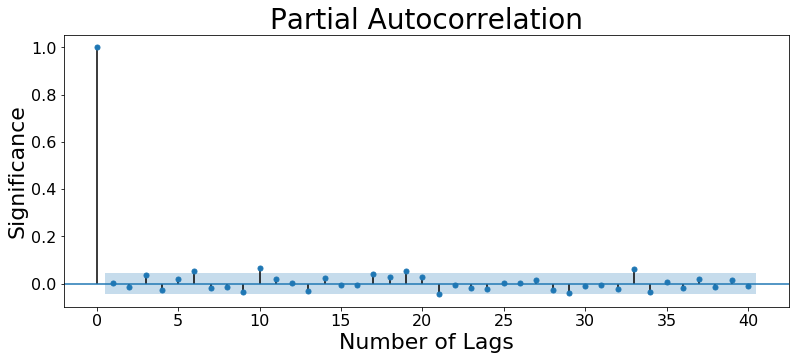

In [188]:
rcParams['figure.figsize'] = 13, 5        #Logged and differenced Bitcoin Prices, statsmodels version

plot_pacf(df_diff_log, lags=40)
plt.title('Partial Autocorrelation', fontsize=28)
plt.xlabel('Number of Lags', fontsize=22)
plt.ylabel('Significance', fontsize=22)
plt.tick_params(axis='both', labelsize=16)

The Partial Autocorrelation Function will tell us how many significants lags to put into an AR model. There are no significant lags for the logged and differenced prices. This means that the ARMA and ARIMA models cannot model these data.

# ARMA model

In [54]:
from statsmodels.tsa.arima_model import ARMA
import statsmodels.api as sm

In [55]:
train = df_log[:int(0.8*(len(df_log)))]        #split into train and validation set
valid = df_log[int(0.8*(len(df_log))):]

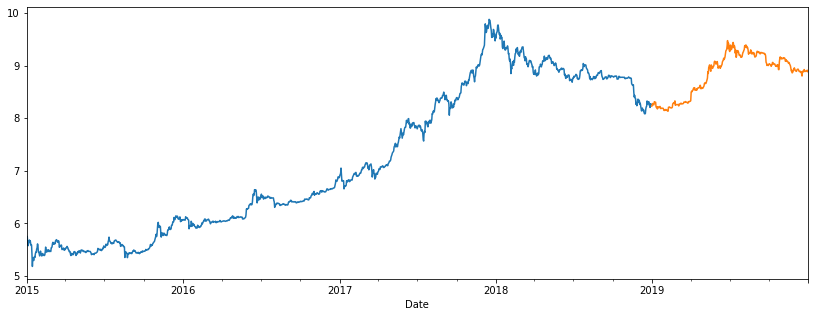

In [57]:
train.plot()    #The 5th year is being used as the validation set
valid.plot()

In [68]:
# Instantiate ARMA model to the logged Bitcoin Prices   #every lag after 1 was insignificant
mod_arma_ar = ARMA(train, order=(1,0))
res_arma_ar = mod_arma_ar.fit()
print(res_arma_ar.summary())

                               ARMA Model Results                              
Dep. Variable:     Daily_Bitcoin_Price   No. Observations:                 1460
Model:                      ARMA(1, 0)   Log Likelihood                2634.147
Method:                        css-mle   S.D. of innovations              0.040
Date:                 Mon, 15 Jun 2020   AIC                          -5262.295
Time:                         16:56:27   BIC                          -5246.436
Sample:                     01-01-2015   HQIC                         -5256.379
                          - 12-30-2018                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         7.0471      1.134      6.215      0.000       4.825       9.270
ar.L1.Daily_Bitcoin_Price     0.9995      0.000   2032.013      0.000       0.

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [66]:
mod_arma_ma = ARMA(train, order=(0,1))     #model only takes 1 lag for MA
res_arma_ma = mod_arma_ma.fit()
print(res_arma_ma.summary())

                               ARMA Model Results                              
Dep. Variable:     Daily_Bitcoin_Price   No. Observations:                 1460
Model:                      ARMA(0, 1)   Log Likelihood               -1562.503
Method:                        css-mle   S.D. of innovations              0.705
Date:                 Mon, 15 Jun 2020   AIC                           3131.007
Time:                         16:55:42   BIC                           3146.865
Sample:                     01-01-2015   HQIC                          3136.923
                          - 12-30-2018                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         7.1721      0.037    196.492      0.000       7.101       7.244
ma.L1.Daily_Bitcoin_Price     0.9795      0.004    266.352      0.000       0.

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


When running (1,1) for the (p,q), the q was insignificant

# AR Prediction

In [74]:
forecast_master_ar = res_arma_ar.forecast(len(valid))
forecast_master_ar

(array([8.25940531, 8.25884747, 8.25828988, 8.25773255, 8.25717548,
        8.25661866, 8.2560621 , 8.25550579, 8.25494974, 8.25439395,
        8.25383841, 8.25328313, 8.25272811, 8.25217333, 8.25161882,
        8.25106456, 8.25051055, 8.2499568 , 8.24940331, 8.24885007,
        8.24829708, 8.24774435, 8.24719187, 8.24663965, 8.24608768,
        8.24553596, 8.2449845 , 8.24443329, 8.24388234, 8.24333164,
        8.24278119, 8.242231  , 8.24168106, 8.24113137, 8.24058194,
        8.24003275, 8.23948382, 8.23893515, 8.23838672, 8.23783855,
        8.23729063, 8.23674296, 8.23619555, 8.23564839, 8.23510147,
        8.23455481, 8.23400841, 8.23346225, 8.23291634, 8.23237069,
        8.23182528, 8.23128013, 8.23073523, 8.23019058, 8.22964618,
        8.22910203, 8.22855813, 8.22801448, 8.22747108, 8.22692793,
        8.22638503, 8.22584238, 8.22529998, 8.22475783, 8.22421593,
        8.22367428, 8.22313288, 8.22259172, 8.22205082, 8.22151016,
        8.22096976, 8.2204296 , 8.21988969, 8.21

In [75]:
forecast_ar = pd.DataFrame(forecast_master_ar[0],index = valid.index,columns=['Prediction'])
forecast_ar
# stderr = pd.DataFrame(forecast_master[1],index = valid.index,columns=['Standard Error'])
# conf_int = pd.DataFrame(forecast_master[2],index = valid.index,columns=['Confidence Interval1','Confidence Interval2'])

,Prediction
Date,
2018-12-31,8.259405
2019-01-01,8.258847
2019-01-02,8.258290
2019-01-03,8.257733
2019-01-04,8.257175
2019-01-05,8.256619
2019-01-06,8.256062
2019-01-07,8.255506
2019-01-08,8.254950


In [76]:
forecast_normal_ar = forecast_ar['Prediction'].transform(np.exp)    #bringing logged values back to normal
forecast_normal_ar

Date
2018-12-31    3863.795651
2019-01-01    3861.640860
2019-01-02    3859.488261
2019-01-03    3857.337852
2019-01-04    3855.189630
2019-01-05    3853.043592
2019-01-06    3850.899735
2019-01-07    3848.758057
2019-01-08    3846.618554
2019-01-09    3844.481225
2019-01-10    3842.346065
2019-01-11    3840.213073
2019-01-12    3838.082246
2019-01-13    3835.953581
2019-01-14    3833.827075
2019-01-15    3831.702725
2019-01-16    3829.580530
2019-01-17    3827.460485
2019-01-18    3825.342589
2019-01-19    3823.226838
2019-01-20    3821.113230
2019-01-21    3819.001763
2019-01-22    3816.892432
2019-01-23    3814.785237
2019-01-24    3812.680174
2019-01-25    3810.577240
2019-01-26    3808.476433
2019-01-27    3806.377750
2019-01-28    3804.281189
2019-01-29    3802.186746
2019-01-30    3800.094419
2019-01-31    3798.004205
2019-02-01    3795.916103
2019-02-02    3793.830108
2019-02-03    3791.746218
2019-02-04    3789.664432
2019-02-05    3787.584745
2019-02-06    3785.507156
2019-02

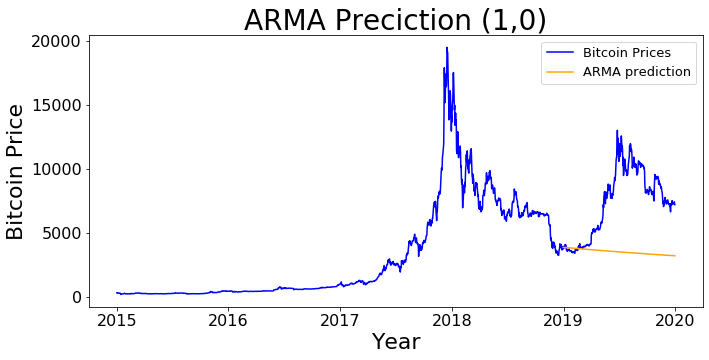

In [518]:
# df.plot()
# forecast_normal_ar.plot()
fig = plt.figure(figsize=(11,5)) 
plt.plot(df, color='blue', label='Bitcoin Prices')
plt.plot(forecast_normal_ar, color='orange', label='ARMA prediction')

plt.legend(loc='best', fontsize=13)
plt.title('ARMA Preciction (1,0)', fontsize=28)
plt.xlabel('Year', fontsize=22)
plt.ylabel('Bitcoin Price', fontsize=22)
plt.tick_params(axis='both', labelsize=16)

In [180]:
from sklearn.metrics import mean_squared_error                               #RMSE
error_ar = np.sqrt(mean_squared_error(np.exp(valid),forecast_normal_ar))
error_ar

4762.301795176295

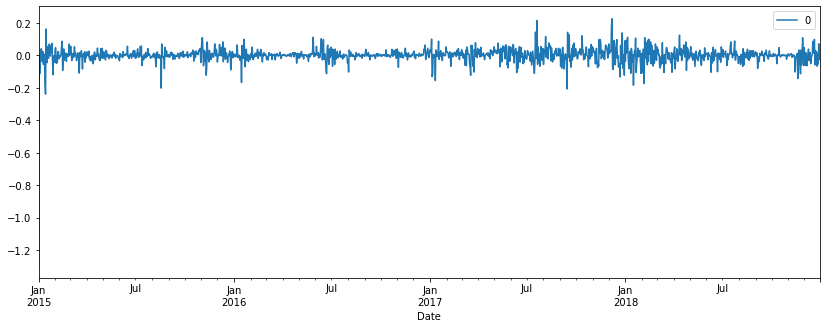

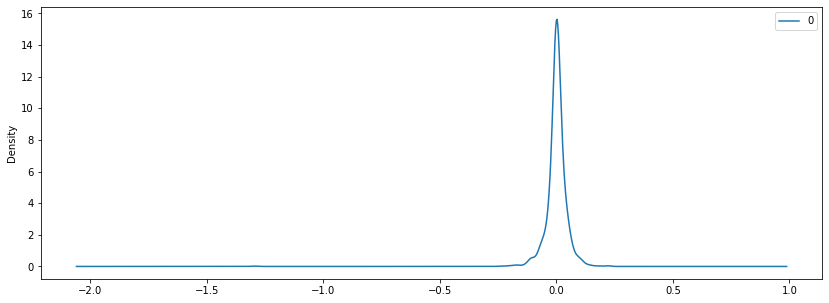

In [86]:
residuals_arma_ar = pd.DataFrame(res_arma_ar.resid)
residuals_arma_ar.plot()
residuals_arma_ar.plot(kind='kde')
pyplot.show()

# MA Prediction

In [118]:
forecast_master_ma = res_arma_ma.forecast(len(valid))
forecast_ma = pd.DataFrame(forecast_master_ma[0],index = valid.index,columns=['Prediction'])
forecast_normal_ma = forecast_ma['Prediction'].transform(np.exp)    #bringing logged values back to normal
forecast_normal_ma.head()

Date
2018-12-31    2496.423240
2019-01-01    1302.525479
2019-01-02    1302.525479
2019-01-03    1302.525479
2019-01-04    1302.525479
Name: Prediction, dtype: float64

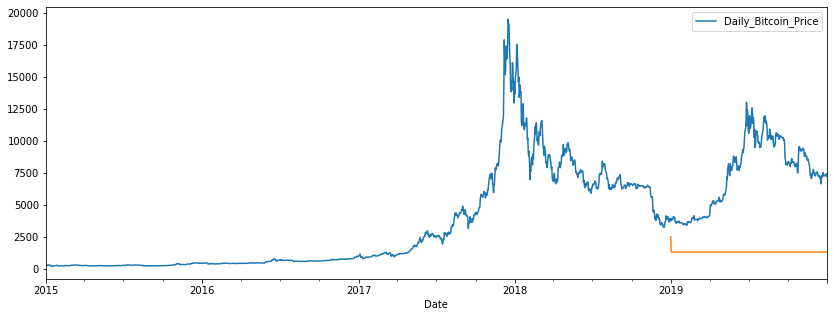

In [83]:
df.plot()                    #Cannot explain this usual prediction
forecast_normal_ma.plot()

In [181]:
error_ma = np.sqrt(mean_squared_error(np.exp(valid),forecast_normal_ma))
error_ma

6629.36010397895

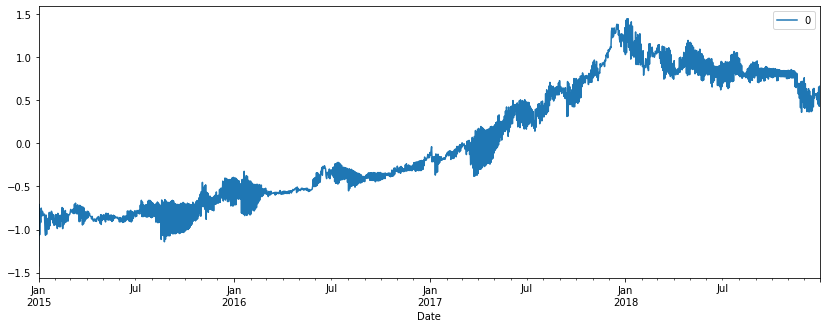

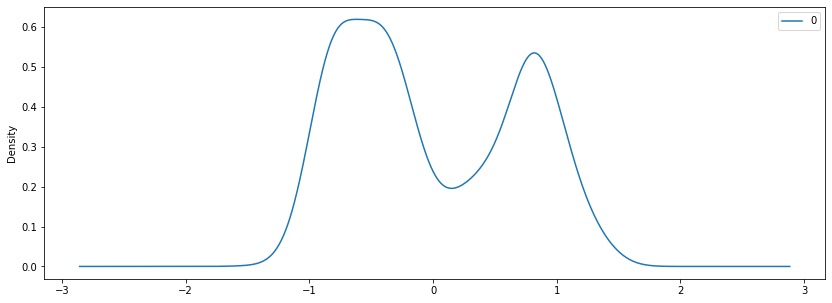

In [85]:
residuals_arma_ma = pd.DataFrame(res_arma_ma.resid)
residuals_arma_ma.plot()
residuals_arma_ma.plot(kind='kde')
pyplot.show()

# ARIMA model

In [87]:
from statsmodels.tsa.arima_model import ARIMA

In [88]:
mod_arima_ar = ARIMA(train, order=(1,1,0))          #(p=1, 1 period lag, q=0)
res_arima_ar = mod_arima_ar.fit(disp=0) 
print(res_arima_ar.summary())

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


                               ARIMA Model Results                               
Dep. Variable:     D.Daily_Bitcoin_Price   No. Observations:                 1459
Model:                    ARIMA(1, 1, 0)   Log Likelihood                2637.066
Method:                          css-mle   S.D. of innovations              0.040
Date:                   Mon, 15 Jun 2020   AIC                          -5268.132
Time:                           19:17:53   BIC                          -5252.276
Sample:                       01-02-2015   HQIC                         -5262.217
                            - 12-30-2018                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           0.0017      0.001      1.641      0.101      -0.000       0.004
ar.L1.D.Daily_Bitcoin_Price     0.0083      0.026      0

In [116]:
forecast_master_arima = res_arima_ar.forecast(len(valid))
forecast_arima = pd.DataFrame(forecast_master_arima[0],index = valid.index,columns=['Prediction'])
forecast_normal_arima = forecast_arima['Prediction'].transform(np.exp)    #bringing logged values back to normal
forecast_normal_arima.head()

Date
2018-12-31    3872.932915
2019-01-01    3879.603795
2019-01-02    3886.283501
2019-01-03    3892.974686
2019-01-04    3899.677391
Name: Prediction, dtype: float64

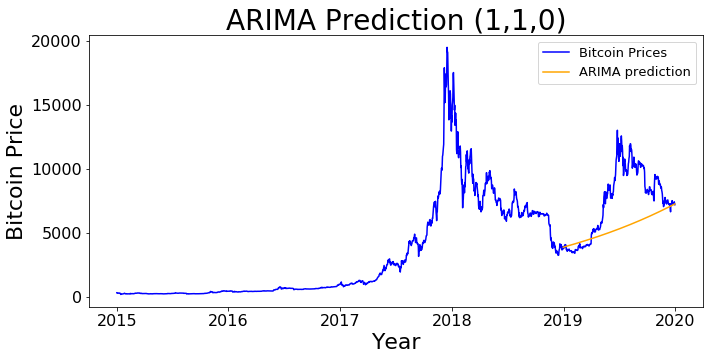

In [567]:
# df.plot()
# forecast_normal_arima.plot()

fig = plt.figure(figsize=(11,5))                 # better than ARMA prediction, but not great even though actual price
plt.plot(df, color='blue', label='Bitcoin Prices')  #converges with prediction by 2020. That is just by luck
plt.plot(forecast_normal_arima, color='orange', label='ARIMA prediction')

plt.legend(loc='best', fontsize=13)
plt.title('ARIMA Prediction (1,1,0)', fontsize=28)
plt.xlabel('Year', fontsize=22)
plt.ylabel('Bitcoin Price', fontsize=22)
plt.tick_params(axis='both', labelsize=16)

In [568]:
error_arima = np.sqrt(mean_squared_error(np.exp(valid),forecast_normal_arima))   #RMSE
error_arima

2952.7812454354203

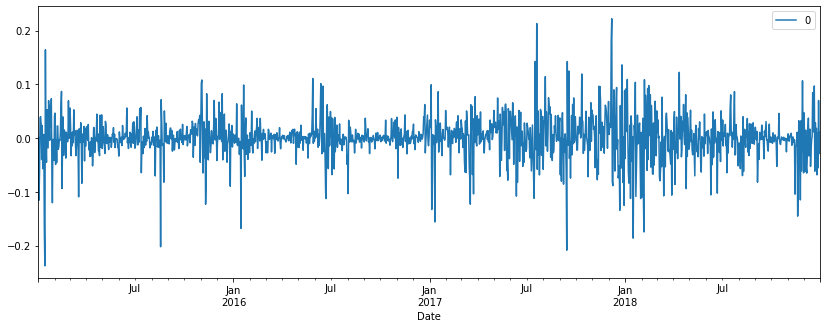

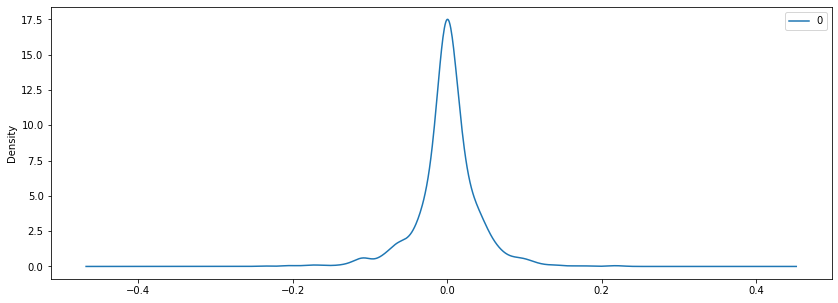

In [94]:
residuals_arima = pd.DataFrame(res_arima_ar.resid)
residuals_arima.plot()
residuals_arima.plot(kind='kde')
pyplot.show()

# Auto-ARIMA

In [98]:
import pmdarima as pm
model_auto = pm.auto_arima(train, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
model_auto_fit = model_auto.fit(train)
print(model_auto_fit.summary())                #like grid search for ARIMA

Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=-5263.103, BIC=-5231.390, Time=1.029 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=-5270.032, BIC=-5259.461, Time=0.132 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=-5268.132, BIC=-5252.276, Time=0.132 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=-5268.135, BIC=-5252.279, Time=0.220 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=-5269.296, BIC=-5264.010, Time=0.041 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=-5266.134, BIC=-5244.992, Time=0.377 seconds
Total fit time: 1.938 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1460
Model:               SARIMAX(0, 1, 0)   Log Likelihood                2637.016
Date:                Mon, 15 Jun 2020   AIC                          -5270.032
Time:                        19:55:48   BIC   

In [102]:
forecast_auto = model_auto_fit.predict(n_periods=len(valid))
forecast_auto = pd.DataFrame(forecast_auto, index = valid.index,columns=['Prediction'])
forecast_normal_auto = forecast_auto['Prediction'].transform(np.exp)       #bringing logged values back to normal
forecast_normal_auto.head()

Date
2018-12-31    3872.608492
2019-01-01    3879.275806
2019-01-02    3885.954599
2019-01-03    3892.644891
2019-01-04    3899.346701
Name: Prediction, dtype: float64

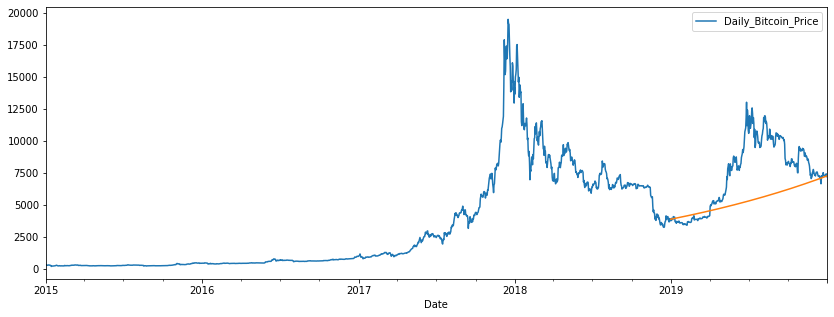

In [103]:
df.plot()
forecast_normal_auto.plot()

In [183]:
error_auto = np.sqrt(mean_squared_error(np.exp(valid),forecast_normal_auto))
error_auto

2953.1805972590555

Results from Auto-ARIMA are very close to ARIMA results

# FB Prophet

In [205]:
from fbprophet import Prophet

In [208]:
df.head()

,Daily_Bitcoin_Price
Date,
2015-01-01,314.248993
2015-01-02,315.032013
2015-01-03,281.082001
2015-01-04,264.195007
2015-01-05,274.473999


In [481]:
fb = df.copy()
fb.head()

,Daily_Bitcoin_Price
Date,
2015-01-01,314.248993
2015-01-02,315.032013
2015-01-03,281.082001
2015-01-04,264.195007
2015-01-05,274.473999


In [482]:
fb.reset_index(level=0, inplace=True)
fb.columns = ['ds', 'y']
fb.head()

,ds,y
0,2015-01-01,314.248993
1,2015-01-02,315.032013
2,2015-01-03,281.082001
3,2015-01-04,264.195007
4,2015-01-05,274.473999


In [483]:
fb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      1826 non-null   datetime64[ns]
 1   y       1826 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 28.7 KB


In [484]:
fb['cap']= 1000000
fb['floor']=0

In [485]:
fb_train = fb[:int(0.8*(len(fb)))]        #split into train and validation set
fb_valid = fb[int(0.8*(len(fb))):]

In [486]:
fb.head()

,ds,y,cap,floor
0,2015-01-01,314.248993,1000000,0
1,2015-01-02,315.032013,1000000,0
2,2015-01-03,281.082001,1000000,0
3,2015-01-04,264.195007,1000000,0
4,2015-01-05,274.473999,1000000,0


In [547]:
Model = Prophet(growth='logistic', interval_width=0.95, changepoint_prior_scale=10)  
FB = Model.fit(fb_train)                                   
                                                           
#When growth is set to "linear", prediction included negative prices and MSE of 8,464, 
#see 'Experimenting with different transformations' notebook for that code and plot  
#selecting "logistic" allows the use of cap and floor, which does not allow the prediction to go outside of the 
#predetermined cap and floor interval

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [548]:
validation_dates = Model.make_future_dataframe(periods=(366), freq='D')
validation_dates['cap']=1000000
validation_dates['floor']=0
validation_dates

,ds,cap,floor
0,2015-01-01,1000000,0
1,2015-01-02,1000000,0
2,2015-01-03,1000000,0
3,2015-01-04,1000000,0
4,2015-01-05,1000000,0
5,2015-01-06,1000000,0
6,2015-01-07,1000000,0
7,2015-01-08,1000000,0
8,2015-01-09,1000000,0
9,2015-01-10,1000000,0


In [489]:
fb_prediction = Model.predict(validation_dates)
fb2 =fb_prediction[['ds', 'yhat_lower', 'yhat_upper', 'yhat']]
fb2.head()

,ds,yhat_lower,yhat_upper,yhat
0,2015-01-01,-776.531960,1615.384922,391.705445
1,2015-01-02,-835.393894,1584.026834,401.305797
2,2015-01-03,-666.739200,1656.739626,426.289873
3,2015-01-04,-854.846984,1535.774315,421.129518
4,2015-01-05,-761.240096,1720.153198,438.743082


In [541]:
fb2.tail()

,ds,yhat_lower,yhat_upper,yhat
1821,2019-12-27,-353.985255,75292.296800,2390.825328
1822,2019-12-28,-406.681562,75243.003033,2414.638319
1823,2019-12-29,-315.285544,77045.289293,2408.569252
1824,2019-12-30,-305.684191,78474.436543,2425.932757
1825,2019-12-31,-355.280250,78153.608742,2428.647556


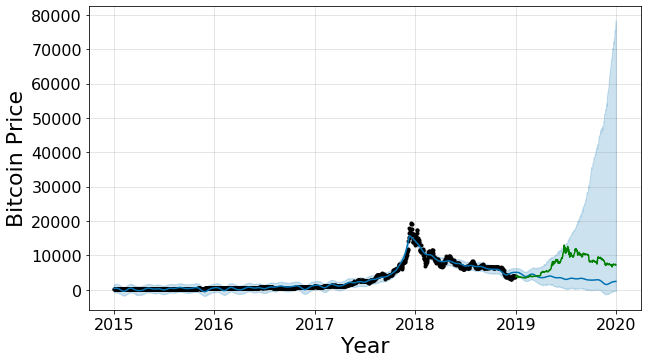

In [607]:
Model.plot(fb2, xlabel= '', ylabel= '', figsize=(8.5, 4.75))  
plt.plot(fb_valid_graph, color='green', label='Bitcoin Prices')
plt.xlabel('Year', fontsize=22)                   #shaded area represents 95% confidence interval
plt.ylabel('Bitcoin Price', fontsize=22)
plt.tick_params(axis='both', labelsize=16)
plt.show()

In [543]:
fb2['yhat'][1461:]   #selecting predictions for 2019 only - for MSE calculation below

1461    5058.575630
1462    5044.636665
1463    5051.087931
1464    5048.717693
1465    5061.274739
1466    5043.126630
1467    5047.106604
1468    5034.688034
1469    5009.792688
1470    5002.989984
1471    4984.912960
1472    4979.245537
1473    4940.387006
1474    4921.302235
1475    4883.696324
1476    4831.819957
1477    4796.662647
1478    4749.359775
1479    4714.168191
1480    4646.116645
1481    4598.839884
1482    4534.735625
1483    4458.751101
1484    4402.556933
1485    4337.934745
1486    4289.733862
1487    4213.503882
1488    4163.312477
1489    4101.888112
1490    4034.394785
1491    3992.596901
1492    3948.240979
1493    3926.009717
1494    3881.155308
1495    3867.321391
1496    3846.693213
1497    3823.782965
1498    3829.608126
1499    3835.089178
1500    3864.021815
1501    3870.730070
1502    3907.909229
1503    3936.797576
1504    3960.983356
1505    4010.604243
1506    4055.765133
1507    4119.528850
1508    4155.585746
1509    4216.110623
1510    4261.945683


In [503]:
fb_valid['y'][1:]    #selecting actual prices for 2019 only - for MSE calculation below

1461     3843.520020
1462     3943.409424
1463     3836.741211
1464     3857.717529
1465     3845.194580
1466     4076.632568
1467     4025.248291
1468     4030.847900
1469     4035.296387
1470     3678.924561
1471     3687.365479
1472     3661.301025
1473     3552.953125
1474     3706.052246
1475     3630.675293
1476     3655.006836
1477     3678.563965
1478     3657.839355
1479     3728.568359
1480     3601.013672
1481     3576.032471
1482     3604.577148
1483     3585.123047
1484     3600.865479
1485     3599.765869
1486     3602.460449
1487     3583.965820
1488     3470.450439
1489     3448.116943
1490     3486.181641
1491     3457.792725
1492     3487.945312
1493     3521.060791
1494     3464.013428
1495     3459.154053
1496     3466.357422
1497     3413.767822
1498     3399.471680
1499     3666.780273
1500     3671.203613
1501     3690.188232
1502     3648.430664
1503     3653.528564
1504     3632.070557
1505     3616.880859
1506     3620.810791
1507     3629.787598
1508     3673

In [604]:
fb_valid_graph =fb_valid.drop(['cap', 'floor'], axis=1, inplace=False)
fb_valid_graph.set_index('ds', inplace=True)
fb_valid_graph

,y
ds,
2018-12-31,3742.700439
2019-01-01,3843.520020
2019-01-02,3943.409424
2019-01-03,3836.741211
2019-01-04,3857.717529
2019-01-05,3845.194580
2019-01-06,4076.632568
2019-01-07,4025.248291
2019-01-08,4030.847900


In [606]:
fb_valid_graph = fb_valid_graph[fb_valid_graph.index != '2018-12-31']
fb_valid_graph

,y
ds,
2019-01-01,3843.520020
2019-01-02,3943.409424
2019-01-03,3836.741211
2019-01-04,3857.717529
2019-01-05,3845.194580
2019-01-06,4076.632568
2019-01-07,4025.248291
2019-01-08,4030.847900
2019-01-09,4035.296387


In [504]:
error_fb = np.sqrt(mean_squared_error(fb_valid['y'][1:],fb2['yhat'][1461:]))
error_fb

5145.137684948069

# ARIMA vs FB Prophet, Round 2

In [556]:
df2 = yf.download("BTC-USD", start="2020-01-01", end="2020-01-31", interval = "1d")
df2.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-01,7194.892090,7254.330566,7174.944336,7200.174316,7200.174316,18565664996
2020-01-02,7202.551270,7212.155273,6935.270020,6985.470215,6985.470215,20802083465
2020-01-03,6984.428711,7413.715332,6914.996094,7344.884277,7344.884277,28111481031
2020-01-04,7345.375488,7427.385742,7309.514160,7410.656738,7410.656738,18444271274
2020-01-05,7410.451660,7544.497070,7400.535645,7411.317383,7411.317383,19725074094


In [558]:
df2['Daily_Bitcoin_Price'] = df2['Close']
df2.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume', 'Close'], axis=1, inplace=True)

In [560]:
df2.head()

,Daily_Bitcoin_Price
Date,
2020-01-01,7200.174316
2020-01-02,6985.470215
2020-01-03,7344.884277
2020-01-04,7410.656738
2020-01-05,7411.317383


In [561]:
model_auto2 = pm.auto_arima(df, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
model_auto_fit2 = model_auto2.fit(df)
print(model_auto_fit2.summary())

Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=25832.774, BIC=25865.830, Time=1.746 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=25836.887, BIC=25847.906, Time=0.126 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=25835.871, BIC=25852.399, Time=0.199 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=25835.691, BIC=25852.219, Time=0.136 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=25835.203, BIC=25840.712, Time=0.125 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=25830.699, BIC=25858.246, Time=0.737 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=25836.005, BIC=25858.042, Time=0.171 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=25829.050, BIC=25851.087, Time=0.546 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=25830.690, BIC=25858.237, Time=0.874 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=25836.292, BIC=25858.329, Time=0.106 seconds
Total fit time: 

In [563]:
forecast_auto2 = model_auto_fit2.predict(n_periods=len(df2))
forecast_auto2 = pd.DataFrame(forecast_auto2, index = df2.index,columns=['Prediction'])
forecast_auto2.head()

,Prediction
Date,
2020-01-01,7195.474913
2020-01-02,7198.343428
2020-01-03,7200.497721
2020-01-04,7203.165866
2020-01-05,7205.464316


In [565]:
forecast_auto2

,Prediction
Date,
2020-01-01,7195.474913
2020-01-02,7198.343428
2020-01-03,7200.497721
2020-01-04,7203.165866
2020-01-05,7205.464316
2020-01-06,7208.028746
2020-01-07,7210.401815
2020-01-08,7212.912560
2020-01-09,7215.324253


(array([737425., 737429., 737433., 737437., 737441., 737445., 737449.,
        737453., 737456.]),
 <a list of 9 Text xticklabel objects>)

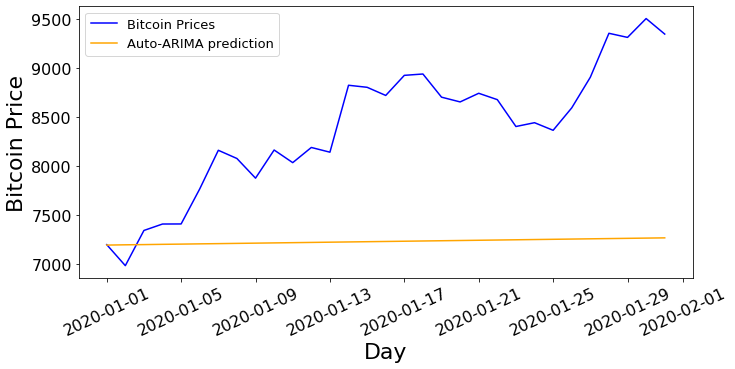

In [610]:
fig = plt.figure(figsize=(11,5)) 
plt.plot(df2, color='blue', label='Bitcoin Prices')
plt.plot(forecast_auto2, color='orange', label='Auto-ARIMA prediction')

plt.legend(loc='best', fontsize=13)
#plt.title('Auto-ARIMA Prediction (1,1,1)', fontsize=28)
plt.xlabel('Day', fontsize=22)
plt.ylabel('Bitcoin Price', fontsize=22)
plt.tick_params(axis='both', labelsize=16)
plt.xticks(rotation=25)

In [578]:
error_auto2 = np.sqrt(mean_squared_error(df2, forecast_auto2))
error_auto2

1318.826976773941

In [580]:
Model2 = Prophet(growth='logistic', interval_width=0.95, changepoint_prior_scale=10)  
FB2 = Model2.fit(fb) 

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [584]:
validation_dates2 = Model2.make_future_dataframe(periods=(31), freq='D')
validation_dates2['cap']=1000000
validation_dates2['floor']=0
fb_prediction2 = Model2.predict(validation_dates2)
fb_prediction2
fb3 =fb_prediction2[['ds', 'yhat_lower', 'yhat_upper', 'yhat']]
fb3.head()

,ds,yhat_lower,yhat_upper,yhat
0,2015-01-01,-2278.736607,2039.480590,-80.316509
1,2015-01-02,-2107.038915,1866.188112,-88.140022
2,2015-01-03,-2057.227649,1963.659903,-93.297487
3,2015-01-04,-2191.936701,1968.590521,-124.995011
4,2015-01-05,-2318.161986,1841.699880,-133.243963


In [598]:
fb3.tail()

,ds,yhat_lower,yhat_upper,yhat
1852,2020-01-27,7484.232201,12076.883509,9788.564168
1853,2020-01-28,7325.129565,12264.827416,9760.459004
1854,2020-01-29,7423.216583,12267.143803,9756.059744
1855,2020-01-30,7250.842373,12240.940723,9742.617723
1856,2020-01-31,7227.721670,12421.710221,9754.503275


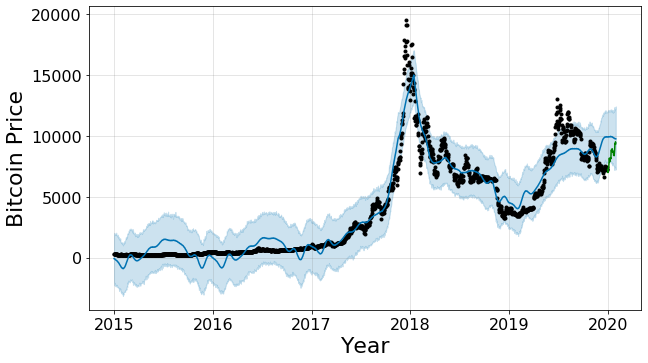

In [618]:
Model2.plot(fb3, xlabel= '', ylabel= '', figsize=(8.5, 4.75))
plt.plot(df2, color='green', label='Bitcoin Prices')
plt.xlabel('Year', fontsize=22)
plt.ylabel('Bitcoin Price', fontsize=22)
plt.tick_params(axis='both', labelsize=16)
plt.show()

In [609]:
fb3['yhat'][1826:]   #selecting predictions for 2019 only - for MSE calculation below

1826    9907.508695
1827    9899.131282
1828    9912.617874
1829    9928.793453
1830    9918.400627
1831    9931.382063
1832    9917.788749
1833    9925.015082
1834    9919.390060
1835    9934.369478
1836    9950.496288
1837    9938.309427
1838    9947.633031
1839    9928.488911
1840    9928.333181
1841    9913.646258
1842    9918.121193
1843    9922.617586
1844    9898.061580
1845    9894.724080
1846    9863.120404
1847    9851.232568
1848    9826.083869
1849    9821.911094
1850    9820.102094
1851    9792.079642
1852    9788.564168
1853    9760.459004
1854    9756.059744
1855    9742.617723
1856    9754.503275
Name: yhat, dtype: float64

In [597]:
error_fb2 = np.sqrt(mean_squared_error(df2,fb3['yhat'][1826:]))
error_fb2

1642.449012863028

In [611]:
fb3

,ds,yhat_lower,yhat_upper,yhat
0,2015-01-01,-2278.736607,2039.480590,-80.316509
1,2015-01-02,-2107.038915,1866.188112,-88.140022
2,2015-01-03,-2057.227649,1963.659903,-93.297487
3,2015-01-04,-2191.936701,1968.590521,-124.995011
4,2015-01-05,-2318.161986,1841.699880,-133.243963
5,2015-01-06,-2218.764447,1889.249590,-167.954177
6,2015-01-07,-2370.488600,2008.106509,-181.700120
7,2015-01-08,-2266.931201,1873.031072,-208.130699
8,2015-01-09,-2351.403275,2054.291459,-213.777804
9,2015-01-10,-2216.240874,1849.509493,-218.096385


In [616]:
fb4 = fb3.iloc[1826:1860]
fb4

,ds,yhat_lower,yhat_upper,yhat
1826,2020-01-01,7827.276299,12055.711416,9907.508695
1827,2020-01-02,7790.027722,12055.472156,9899.131282
1828,2020-01-03,7815.585222,12137.092539,9912.617874
1829,2020-01-04,7852.266401,12022.699315,9928.793453
1830,2020-01-05,7697.668255,12040.381689,9918.400627
1831,2020-01-06,7784.641047,12005.905249,9931.382063
1832,2020-01-07,7816.826975,12122.166863,9917.788749
1833,2020-01-08,7888.121851,11983.871866,9925.015082
1834,2020-01-09,7888.704540,12007.489601,9919.390060
1835,2020-01-10,7841.632000,12025.337449,9934.369478


In [624]:
#fb4.drop(['yhat_lower', 'yhat_upper'], axis=1, inplace=True)
#fb4.set_index('ds', inplace=True)
fb4


,yhat
ds,
2020-01-01,9907.508695
2020-01-02,9899.131282
2020-01-03,9912.617874
2020-01-04,9928.793453
2020-01-05,9918.400627
2020-01-06,9931.382063
2020-01-07,9917.788749
2020-01-08,9925.015082
2020-01-09,9919.390060


(array([737425., 737429., 737433., 737437., 737441., 737445., 737449.,
        737453., 737456.]),
 <a list of 9 Text xticklabel objects>)

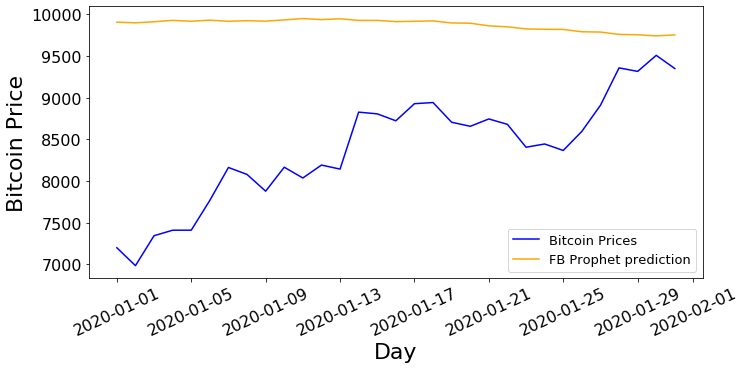

In [625]:
fig = plt.figure(figsize=(11,5)) 
plt.plot(df2, color='blue', label='Bitcoin Prices')
plt.plot(fb4, color='orange', label='FB Prophet prediction')

plt.legend(loc='best', fontsize=13)
#plt.title('Auto-ARIMA Prediction (1,1,1)', fontsize=28)
plt.xlabel('Day', fontsize=22)
plt.ylabel('Bitcoin Price', fontsize=22)
plt.tick_params(axis='both', labelsize=16)
plt.xticks(rotation=25)